In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Given the above statistical analysis. A very intriguing question arises. Is it possible for the columns including "Glucose", "BloodPressure", "SkinThickness", "Insulin", and "BMI" to have minimum value of zero? The value of zero doesn't make sense. For example, a person with BMI means a person weight zero kilogram. It is possible that those instances were treated as missing value (replace with zero) or recording error from human.

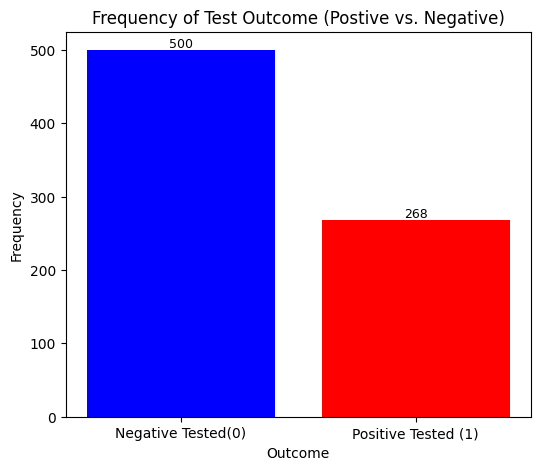

In [4]:
import matplotlib.pyplot as plt

# Count the frequency of Test Outcome
outcome_counts = df['Outcome'].value_counts()

# Create a bar chart
plt.figure(figsize=(6, 5))

# Plot each class separately with explicit labels
plt.bar(x=[0, 1], height=outcome_counts, color=['blue', 'red'])
plt.title('Frequency of Test Outcome (Postive vs. Negative)')
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Negative Tested(0)', 'Positive Tested (1)'], rotation=0)

# Annotate the bars with their frequencies
for i, count in enumerate(outcome_counts):
    plt.text(i, count, str(count), ha='center', va='bottom',fontsize=9)

plt.show()

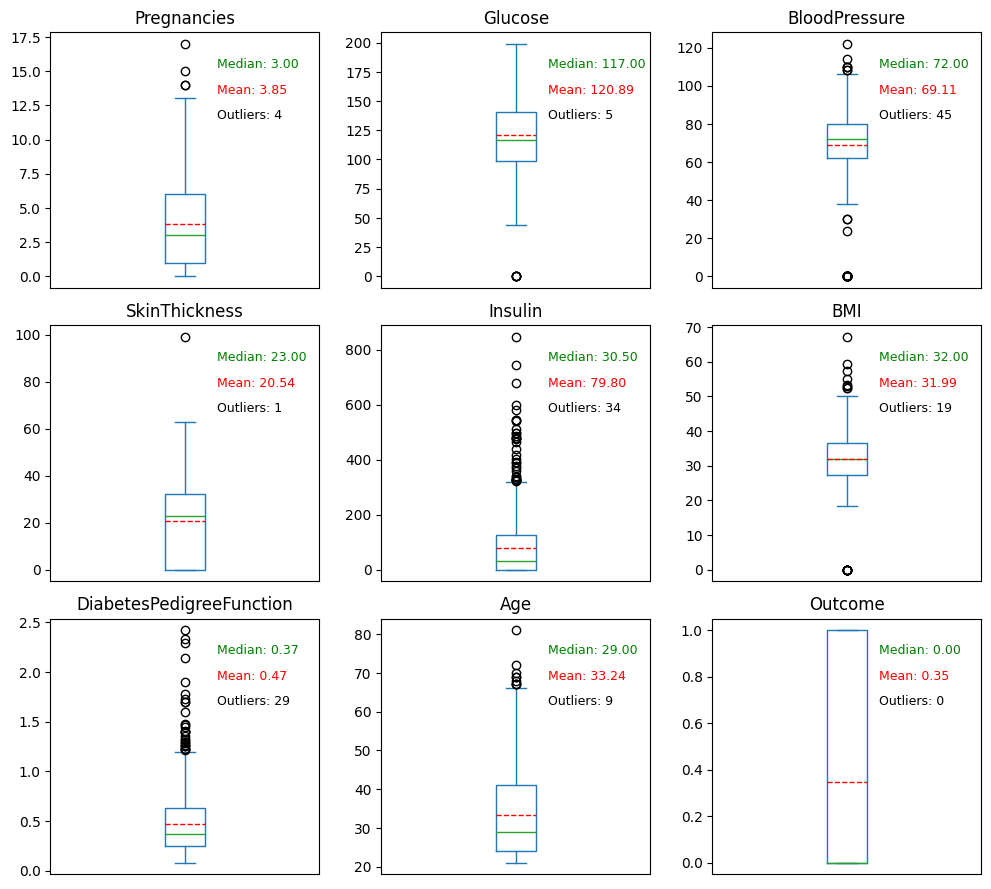

In [5]:
num_columns = len(df.columns)
num_rows = (num_columns // 3) + (num_columns % 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 6 * num_rows // 2))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    boxplot = df[col].plot(kind='box', ax=ax, sharex=False, sharey=False, 
                           meanline=True, showmeans =True, meanprops={'color': 'red', 'linestyle': '--'})
    ax.set_title(f'{col}')
    ax.set_xticks([])

    # Calculate the median and mean
    median, mean = df[col].median(), df[col].mean() 
    
    # Mean and Median Annotation
    ax.text(0.62, 0.9, f'Median: {median:.2f}', transform=ax.transAxes, 
            fontsize=9, verticalalignment='top',color='green')
    ax.text(0.62, 0.8, f'Mean: {mean:.2f}', transform=ax.transAxes, 
            fontsize=9, verticalalignment='top',color='red')

    # Outlier calculation and Annotation
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    ax.text(0.62, 0.7, f'Outliers: {len(outliers)}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


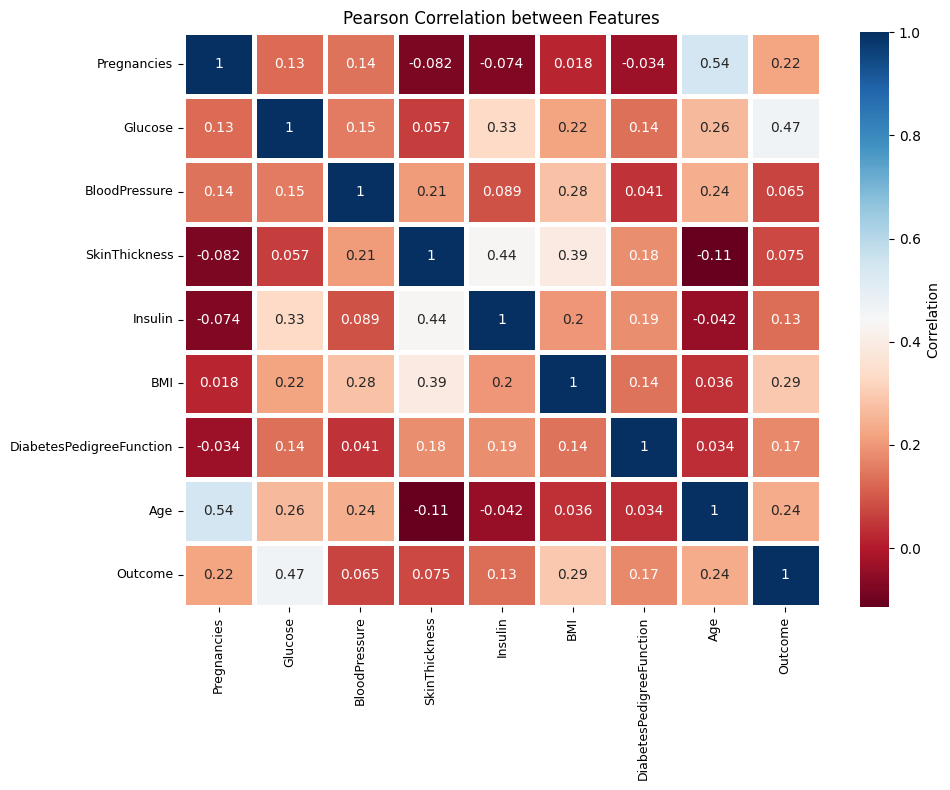

In [6]:
import seaborn as sns

plt.figure(figsize=(10, 8))
hmap = sns.heatmap(df.corr(), annot=True, cmap='RdBu', linewidths=3.5, linecolor='white')

# Add a title
plt.title("Pearson Correlation between Features")

hmap.set_xticklabels(hmap.get_xticklabels(), rotation=90, fontsize=9)
hmap.set_yticklabels(hmap.get_yticklabels(), fontsize=9)

# Customize the legend
cbar = hmap.collections[0].colorbar
cbar.set_label('Correlation', fontsize=10)
cbar.ax.tick_params(labelsize=10)

# Add additional artistic elements
plt.tight_layout()
plt.show()

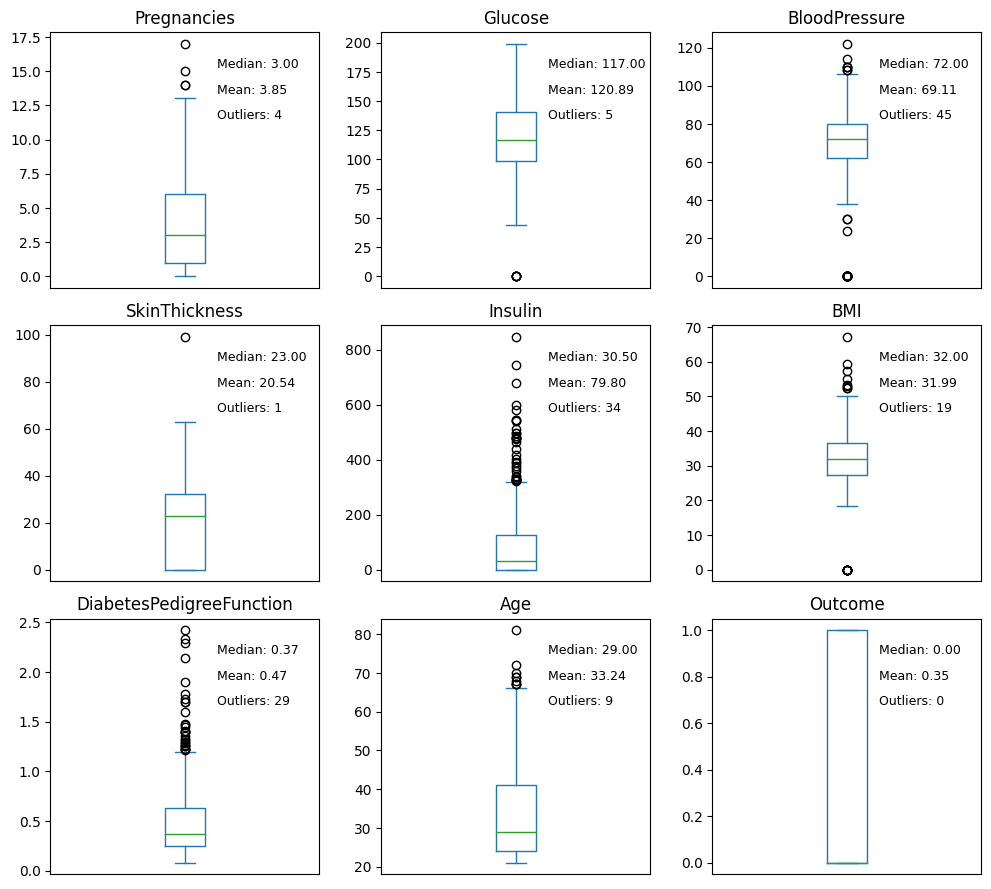

In [7]:
num_columns = len(df.columns)
num_rows = (num_columns // 3) + (num_columns % 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 6 * num_rows // 2))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    boxplot = df[col].plot(kind='box', ax=ax, sharex=False, sharey=False)
    ax.set_title(f'{col}')
    ax.set_xticks([])

    # Calculate and annotate the median and mean
    median = df[col].median()
    mean = df[col].mean()
    ax.text(0.62, 0.9, f'Median: {median:.2f}', transform=ax.transAxes, fontsize=9, verticalalignment='top')
    ax.text(0.62, 0.8, f'Mean: {mean:.2f}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

    # Calculate and annotate the count of outliers
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    ax.text(0.62, 0.7, f'Outliers: {len(outliers)}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

<Figure size 2000x1000 with 0 Axes>

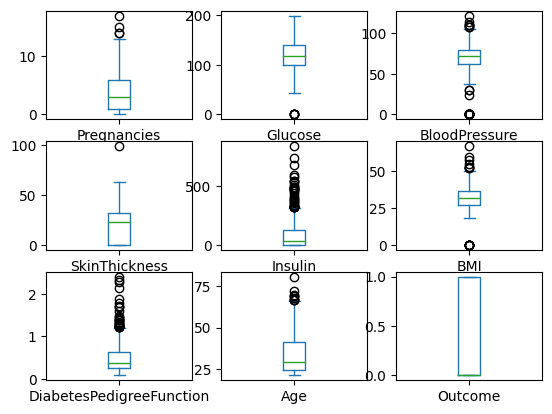

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
df.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.show()

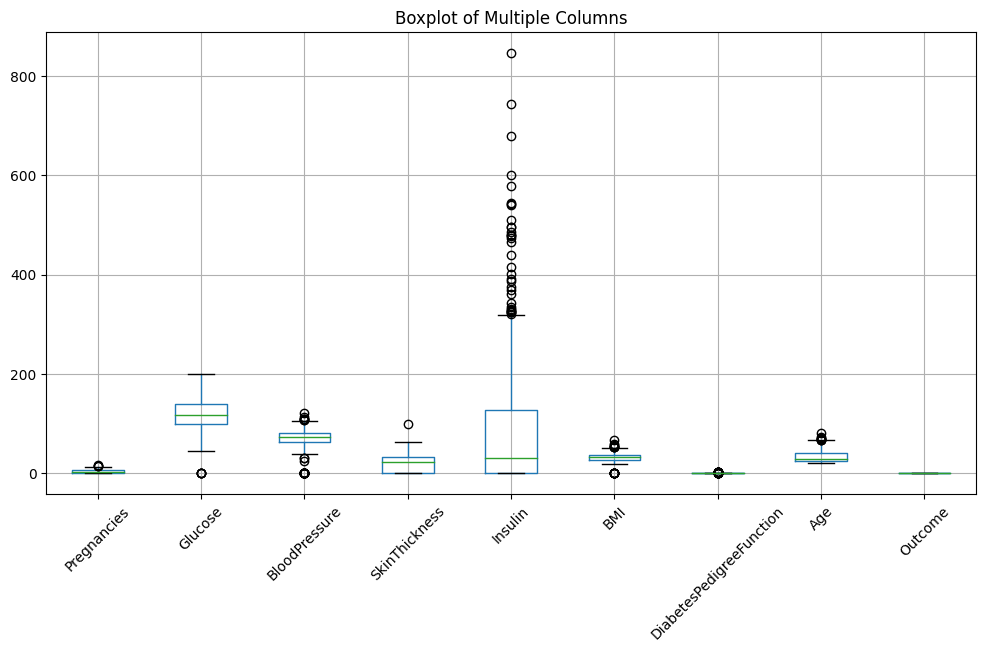

In [9]:
# Assuming your DataFrame is named 'df'
df.boxplot(figsize=(12, 6))  # You can adjust the figsize as needed
plt.title('Boxplot of Multiple Columns')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

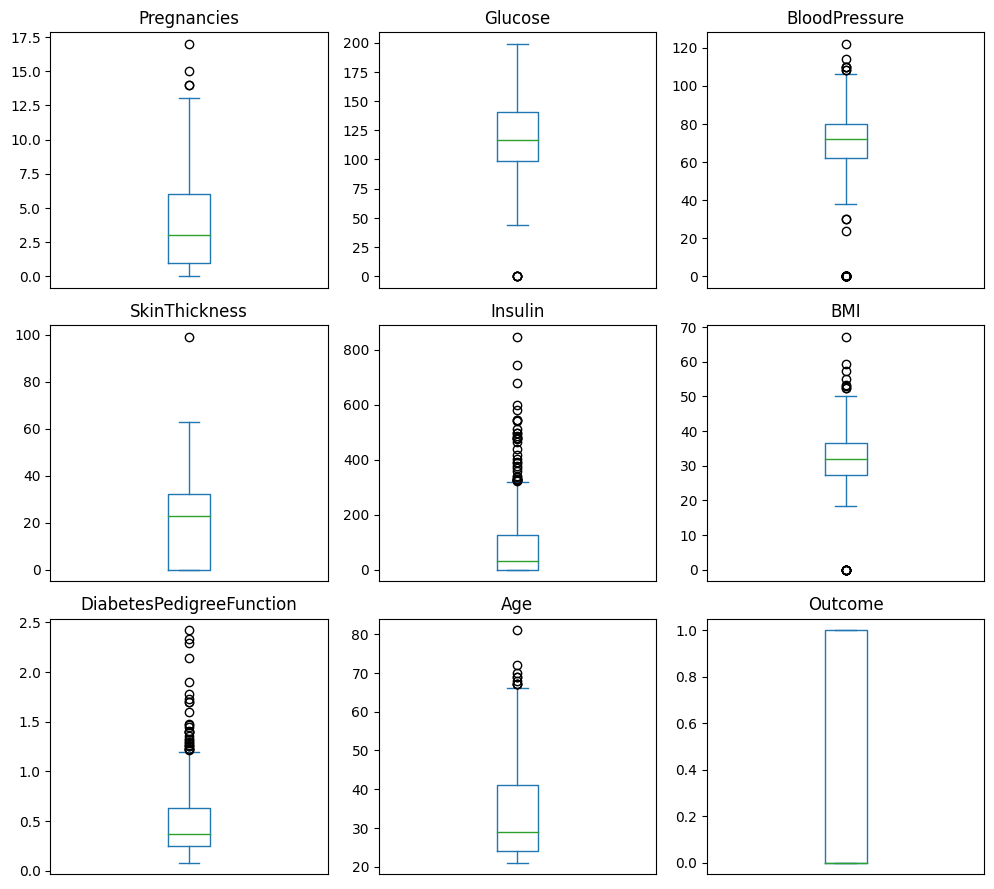

In [10]:
num_columns = len(df.columns)
num_rows = (num_columns // 3) + (num_columns % 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 6 * num_rows//2))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    df[col].plot(kind='box', ax=ax, sharex=False, sharey=False)
    ax.set_title(f'{col}')
    ax.set_xticks([])

for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and display
plt.tight_layout()
plt.show()


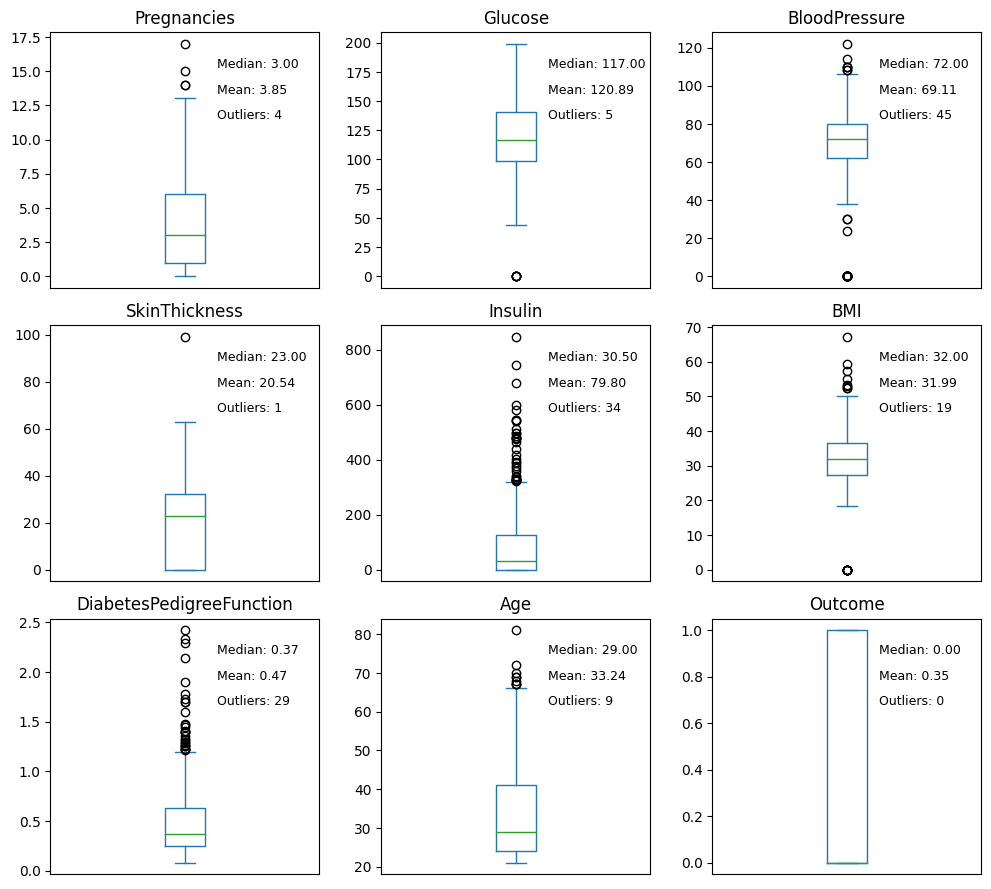

In [11]:
num_columns = len(df.columns)
num_rows = (num_columns // 3) + (num_columns % 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 6 * num_rows // 2))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    boxplot = df[col].plot(kind='box', ax=ax, sharex=False, sharey=False)
    ax.set_title(f'{col}')
    ax.set_xticks([])

    # Calculate and annotate the median and mean
    median = df[col].median()
    mean = df[col].mean()
    ax.text(0.62, 0.9, f'Median: {median:.2f}', transform=ax.transAxes, fontsize=9, verticalalignment='top')
    ax.text(0.62, 0.8, f'Mean: {mean:.2f}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

    # Calculate and annotate the count of outliers
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    ax.text(0.62, 0.7, f'Outliers: {len(outliers)}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()